# Data Fusion Premiere Project on African Conflict Data

This analysis focuses on the African Conflict Dataset from 1997 to 2020. The dataset, obtained from [Kaggle](https://www.kaggle.com/datasets/lumierebatalong/africa-conflict-19972020?rvi=1), contains information on various variables

- event_date: The day,month and year on which an event took place.
- event_type: The type of event.
- sub_event_type: The type of sub event of event.
- actor1: The named actor involved in the event.
- actor2: The named actor involved in the event.
- interaction: A numeric code indicating the interaction between types of ACTOR1 and ACTOR2.
- region: The region of the world where the event took place.
- admin1: The largest sub-national administrative region in which the event took place.
- admin2: The second largest sub-national administrative region in which the event took place.
- admin3: The third largest sub-national administrative region in which the event took place.
- location: The location in which the event took place.
- latitude: The latitude of the location.
- longitude: The longitude of the location
- source: The source of the event report.
- source_scale: The scale (local, regional, national, international) of the source
- notes:A short description of the event
- fatalities:The number of reported fatalities which occurred during the event
    
The analysis includes visualizations of the distribution of conflicts over time, the number of fatalities by region, and the types of events. Additionally, a heatmap is created to visualize the concentration of events in different regions. The analysis also includes a word cloud analysis of the event notes to identify common themes.

In [2]:
!pip install missingno

In [3]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import geopandas as gpd
import plotly.express as px
from IPython.display import IFrame
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set(rc={'figure.figsize':(12,5)})
pd.set_option('display.max_columns', 50)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Assessing Dataset

In [ ]:
# Load the dataset
data = pd.read_csv("Africa_1997-2020_Jan08.csv", sep=";")

In [6]:
# Checking the data shape
print(f"This dataset contains {data.shape[0]} rows and {data.shape[1]} columns")
# Checking the feature types
print(f"With {data.select_dtypes(include=['object']).shape[1]} categorical features and {data.select_dtypes(include=['int', 'float']).shape[1]} numerical features")

This dataset contains 65535 rows and 29 columns
With 19 categorical features and 10 numerical features


In [7]:
data.tail(2)

ISO event_id_cnty  event_id_no_cnty        event_date  year  \
65533  404        KEN323               323  14-novembre-1998  1998   
65534  404        KEN322               322  14-novembre-1998  1998   

       time_precision event_type sub_event_type  \
65533               1    Battles    Armed clash   
65534               1    Battles    Armed clash   

                                                actor1 assoc_actor_1  inter1  \
65533  SPLM/A: Sudan People's Liberation Movement/Army           NaN       2   
65534  SPLM/A: Sudan People's Liberation Movement/Army           NaN       2   

                                                  actor2 assoc_actor_2  \
65533  SPLM/A-Kerubino: Sudan People's Liberation Mov...           NaN   
65534  SPLM/A-Kerubino: Sudan People's Liberation Mov...           NaN   

       inter2  interaction          region country   admin1   admin2  \
65533       2           22  Eastern Africa   Kenya  Nairobi  Starehe   
65534       2           22  Eastern Africa   Kenya  Nairobi  Starehe   

                admin3 location latitude longitude  geo_precision      source  \
65533  Nairobi Central  Nairobi    -1283     36817              1  All Africa   
65534  Nairobi Central  Nairobi    -1283     36817              1  All Africa   

      source_scale                                              notes  \
65533     Regional       Rival SPLA factions battle at police station   
65534     Regional  Gang of youth loyal to Kerubinos SPLA faction ...   

       fatalities   timestamp  
65533           0  1583194169  
65534           0  1583194169

In [8]:
# ProfileReport(data)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ISO               65535 non-null  int64 
 1   event_id_cnty     65535 non-null  object
 2   event_id_no_cnty  65535 non-null  int64 
 3   event_date        65535 non-null  object
 4   year              65535 non-null  int64 
 5   time_precision    65535 non-null  int64 
 6   event_type        65535 non-null  object
 7   sub_event_type    65535 non-null  object
 8   actor1            65535 non-null  object
 9   assoc_actor_1     12768 non-null  object
 10  inter1            65535 non-null  int64 
 11  actor2            50346 non-null  object
 12  assoc_actor_2     11167 non-null  object
 13  inter2            65535 non-null  int64 
 14  interaction       65535 non-null  int64 
 15  region            65535 non-null  object
 16  country           65535 non-null  object
 17  admin1      

In [10]:
# Checking a summary statistic for categorical variable only
data.describe(include="object")

event_id_cnty    event_date event_type sub_event_type  \
count          65535         65535      65535          65535   
unique         65535          8244          6             25   
top             ALG1  06-août-2016    Battles    Armed clash   
freq               1           113      20148          18125   

                      actor1                  assoc_actor_1  \
count                  65535                          12768   
unique                  1645                           1866   
top     Protesters (Algeria)  Oromo Ethnic Group (Ethiopia)   
freq                    5916                            689   

                                          actor2  \
count                                      50346   
unique                                      1402   
top     Civilians (Democratic Republic of Congo)   
freq                                        7071   

                               assoc_actor_2         region  \
count                                  11167          65535   
unique                                  2069              5   
top     Women (Democratic Republic of Congo)  Middle Africa   
freq                                     638          33945   

                             country     admin1 admin2    admin3 location  \
count                          65535      65535  65535     52331    65535   
unique                            20        317   1832      2672     8381   
top     Democratic Republic of Congo  Nord-Kivu   Beni  Rutshuru   Bangui   
freq                           19271       7423   2143      1492      970   

       latitude longitude       source source_scale  \
count     65535     65535        65535        65535   
unique     6456      6506         4129           23   
top        4361     18555  Radio Okapi     National   
freq        965       965         5935        23779   

                                  notes  
count                             62931  
unique                            55547  
top     ONLF attacks Ethiopian soldiers  
freq                                226

### Cleaning Dataset

In [11]:
# Formating column name
data.columns = [col.lower() for col in data.columns]
data.columns

Index(['iso', 'event_id_cnty', 'event_id_no_cnty', 'event_date', 'year',
       'time_precision', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2',
       'interaction', 'region', 'country', 'admin1', 'admin2', 'admin3',
       'location', 'latitude', 'longitude', 'geo_precision', 'source',
       'source_scale', 'notes', 'fatalities', 'timestamp'],
      dtype='object')

In [12]:
# msno.matrix(data);

In [13]:
# Checking for missing values
((data.isnull().sum()[data.isnull().sum()>0]/ len(data))*100).sort_values(ascending=False)

assoc_actor_2    82.960250
assoc_actor_1    80.517281
actor2           23.176928
admin3           20.148013
notes             3.973449
dtype: float64

It can be observed that the following columns, such as `associated actors`, `actors`, `admin` and `notes`

In [14]:
# Drop identifiers datatype and features with over 70% missing values
data.drop(columns=['iso', 'event_id_cnty', 'event_id_no_cnty', 'assoc_actor_1', 'assoc_actor_2', 'timestamp'], inplace=True)
data.columns

Index(['event_date', 'year', 'time_precision', 'event_type', 'sub_event_type',
       'actor1', 'inter1', 'actor2', 'inter2', 'interaction', 'region',
       'country', 'admin1', 'admin2', 'admin3', 'location', 'latitude',
       'longitude', 'geo_precision', 'source', 'source_scale', 'notes',
       'fatalities'],
      dtype='object')

In [15]:
# Dropping missing values
data["actor2"].fillna(' ', inplace=True)
data["admin3"].fillna(' ', inplace=True)
data.dropna(inplace=True)
data.shape

(62931, 23)

In [16]:
# data.isnull().sum()

In [17]:
# Convert latitude and longitude columns to float
data['latitude'] = data['latitude'].str.replace(',', '.').astype(float)
data['longitude'] = data['longitude'].str.replace(',', '.').astype(float)

In [18]:
# Clean date column and change data type
def proper_date(row):
    month = {'janvier': 1, 'février':2, 'mars':3, 'avril':4, 'mai':5,
            'juin':6, 'juillet':7, 'août':8, 'septembre':9, 'octobre':10,
            'novembre':11, 'décembre':12}
    c = row.split('-')
    date = f'{c[0]}/{month[c[1]]}/{c[2]}'
    return date

In [19]:
data["event_date"] = data["event_date"] .apply(proper_date)

In [20]:
# Converting data type to date time and extracting year
data["event_date"]   = pd.to_datetime(data["event_date"], dayfirst=True)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62931 entries, 0 to 65534
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   event_date      62931 non-null  datetime64[ns]
 1   year            62931 non-null  int64         
 2   time_precision  62931 non-null  int64         
 3   event_type      62931 non-null  object        
 4   sub_event_type  62931 non-null  object        
 5   actor1          62931 non-null  object        
 6   inter1          62931 non-null  int64         
 7   actor2          62931 non-null  object        
 8   inter2          62931 non-null  int64         
 9   interaction     62931 non-null  int64         
 10  region          62931 non-null  object        
 11  country         62931 non-null  object        
 12  admin1          62931 non-null  object        
 13  admin2          62931 non-null  object        
 14  admin3          62931 non-null  object        
 15  lo

### Exploring Variables

### Univariate Analysis

In [22]:
# Separating the different data type
cat_col =  data.select_dtypes(include=['object'])
num_col =  data.select_dtypes(include=['float', 'int'])
date_col =  data.select_dtypes(include=['datetime64[ns]'])

In [23]:
# Checking the updated data types
print(f"For this analysis there are {cat_col.shape[1]} categorical features, {num_col.shape[1]} numerical features and {date_col.shape[1]} datetime features")

For this analysis there are 13 categorical features, 9 numerical features and 1 datetime features


#### Categorical variables

In [24]:
# Checking for number of cardinality
cat_col.nunique()

event_type            6
sub_event_type       25
actor1             1638
actor2             1394
region                5
country              20
admin1              317
admin2             1811
admin3             2606
location           8178
source             4083
source_scale         23
notes             55547
dtype: int64

In [25]:
# Calculate frequency of event_type
event_type_counts = cat_col['event_type'].value_counts()
total_events = len(cat_col)

event_type_pct = (event_type_counts / total_events) * 100
event_type_distribution = pd.concat([event_type_counts, event_type_pct], axis=1, keys=['Count', 'Percentage'])

event_type_distribution

Count  Percentage
Violence against civilians  18183   28.893550
Battles                     18013   28.623413
Protests                    13648   21.687245
Riots                        5766    9.162416
Strategic developments       5128    8.148607
Explosions/Remote violence   2193    3.484769

_We observed that there is a high number of battles (28.8%) and violence against civilians (28.6%) which indicates the prevalence of armed conflicts and human rights abuses. Protests and riots (over 30%) also appear to be relatively common, highlighting the presence of social and political unrest. The occurrence of strategic developments and explosions/remote violence suggests the involvement of organized groups and the use of tactics such as bombings or remote attacks_

In [26]:
# Calculate frequency of conflict across Regions
cat_col["region"].value_counts(normalize=True)*100

Middle Africa      49.929288
Eastern Africa     24.711192
Northern Africa    15.766474
Western Africa      9.470690
Southern Africa     0.122356
Name: region, dtype: float64

_We observe that almost 50% of African conflict happened in Middle Africa which is a matter of concern and South AFrica with very minimal conflict cases_

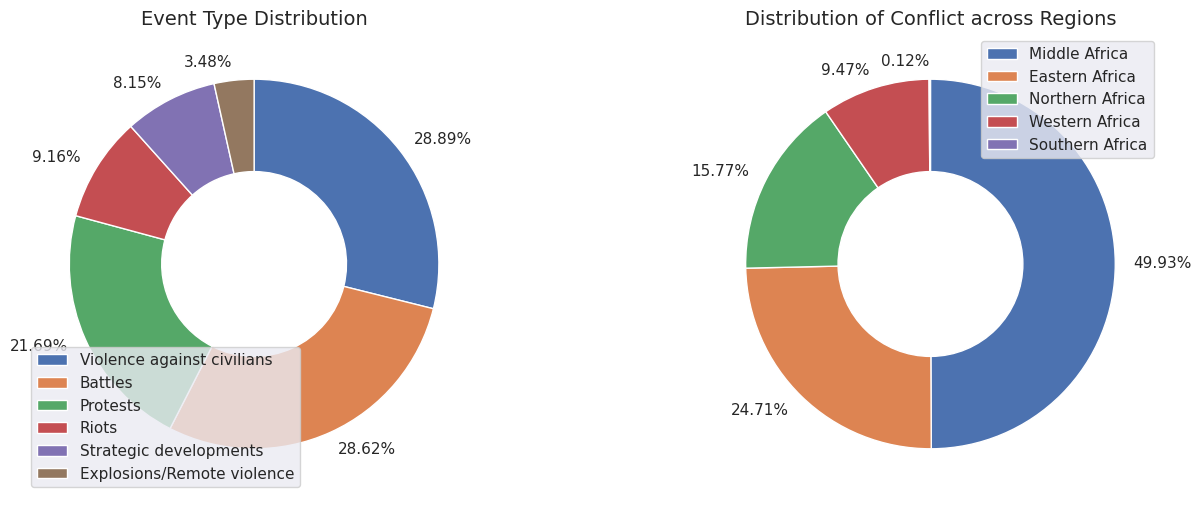

In [27]:
# Plot of Event_type and Region
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plt.subplot(1, 2, 1)
# Plot of Event Type
statuscount = round(cat_col["event_type"].value_counts(normalize=True)*100,2)
plt.pie(statuscount, labels=[f"{str(x)}%" for x in statuscount.values], startangle=90, counterclock = False, wedgeprops = {'width': 0.5});
plt.title('Event Type Distribution', fontsize=14)
plt.legend(statuscount.index);

plt.subplot(1, 2, 2)
# Plot of Region
statuscount2 = round(cat_col["region"].value_counts(normalize=True)*100,2)
plt.pie(statuscount2, labels=[f"{str(x)}%" for x in statuscount2.values], startangle=90, counterclock = False, wedgeprops = {'width': 0.5});
plt.title('Distribution of Conflict across Regions', fontsize=14)
plt.legend(statuscount2.index);

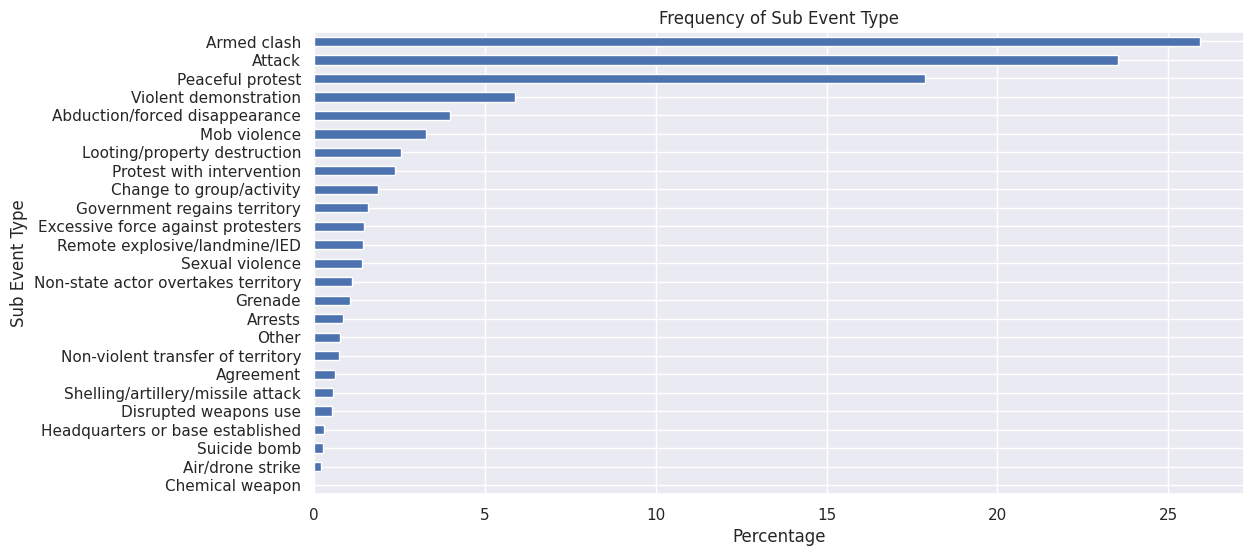

In [28]:
# Plot of sub_event frequency
plt.figure(figsize=(12,6))
(cat_col["sub_event_type"].value_counts(normalize=True)*100).sort_values(ascending=True).plot(kind='barh',
                            title='Frequency of Sub Event Type',ylabel='Sub Event Type', xlabel='Percentage');

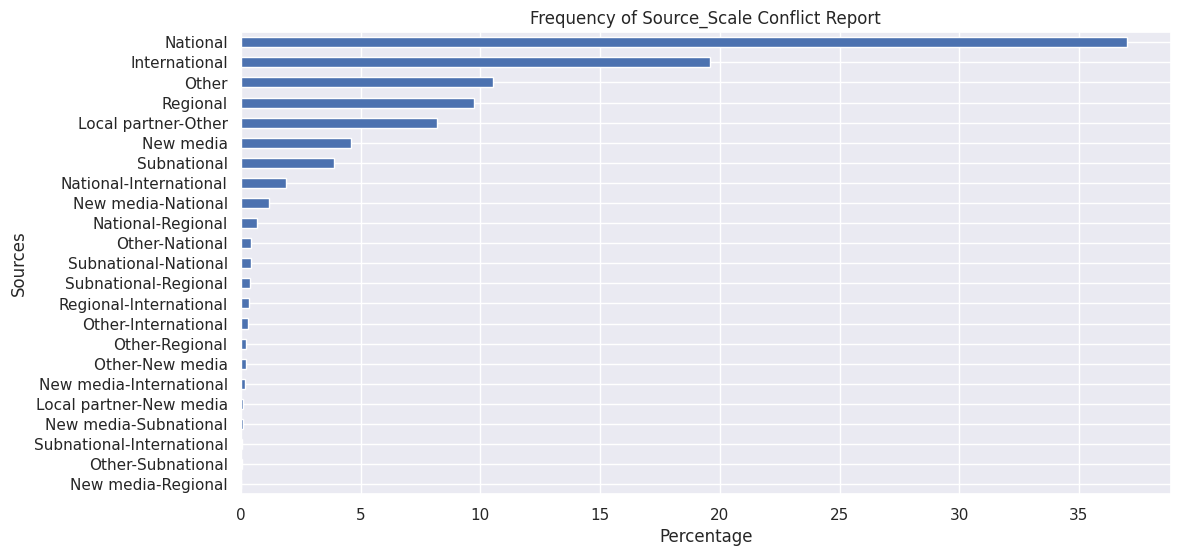

In [29]:
# Plot of sub_scale frequency
plt.figure(figsize=(12,6))
(cat_col["source_scale"].value_counts(normalize=True)*100).sort_values(ascending=True).plot(kind='barh',
                            title='Frequency of Source_Scale Conflict Report',ylabel='Sources', xlabel='Percentage');

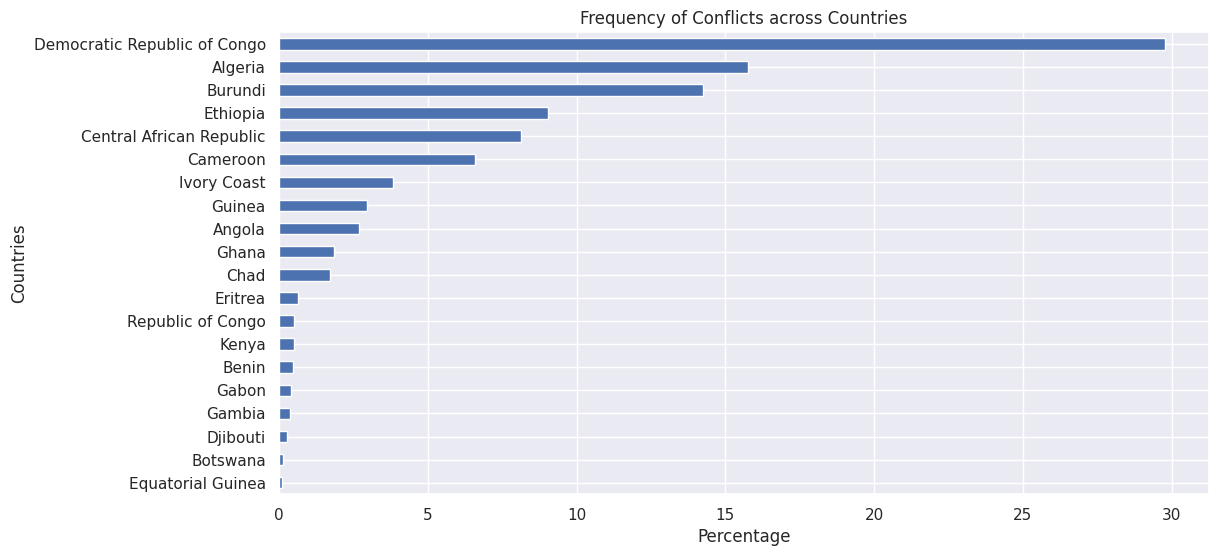

In [30]:
# Plot of frequency across countries
plt.figure(figsize=(12,6))
(cat_col["country"].value_counts(normalize=True)*100).sort_values(ascending=True).plot(kind='barh',
                            title='Frequency of Conflicts across Countries',ylabel='Countries', xlabel='Percentage');

In [31]:
# For categorical variables with very high cardinality we employ word cloud to visualize
cat_col_high = ['actor1', 'admin1', 'actor2', 'admin2', 'admin3', 'location', 'source', 'notes']

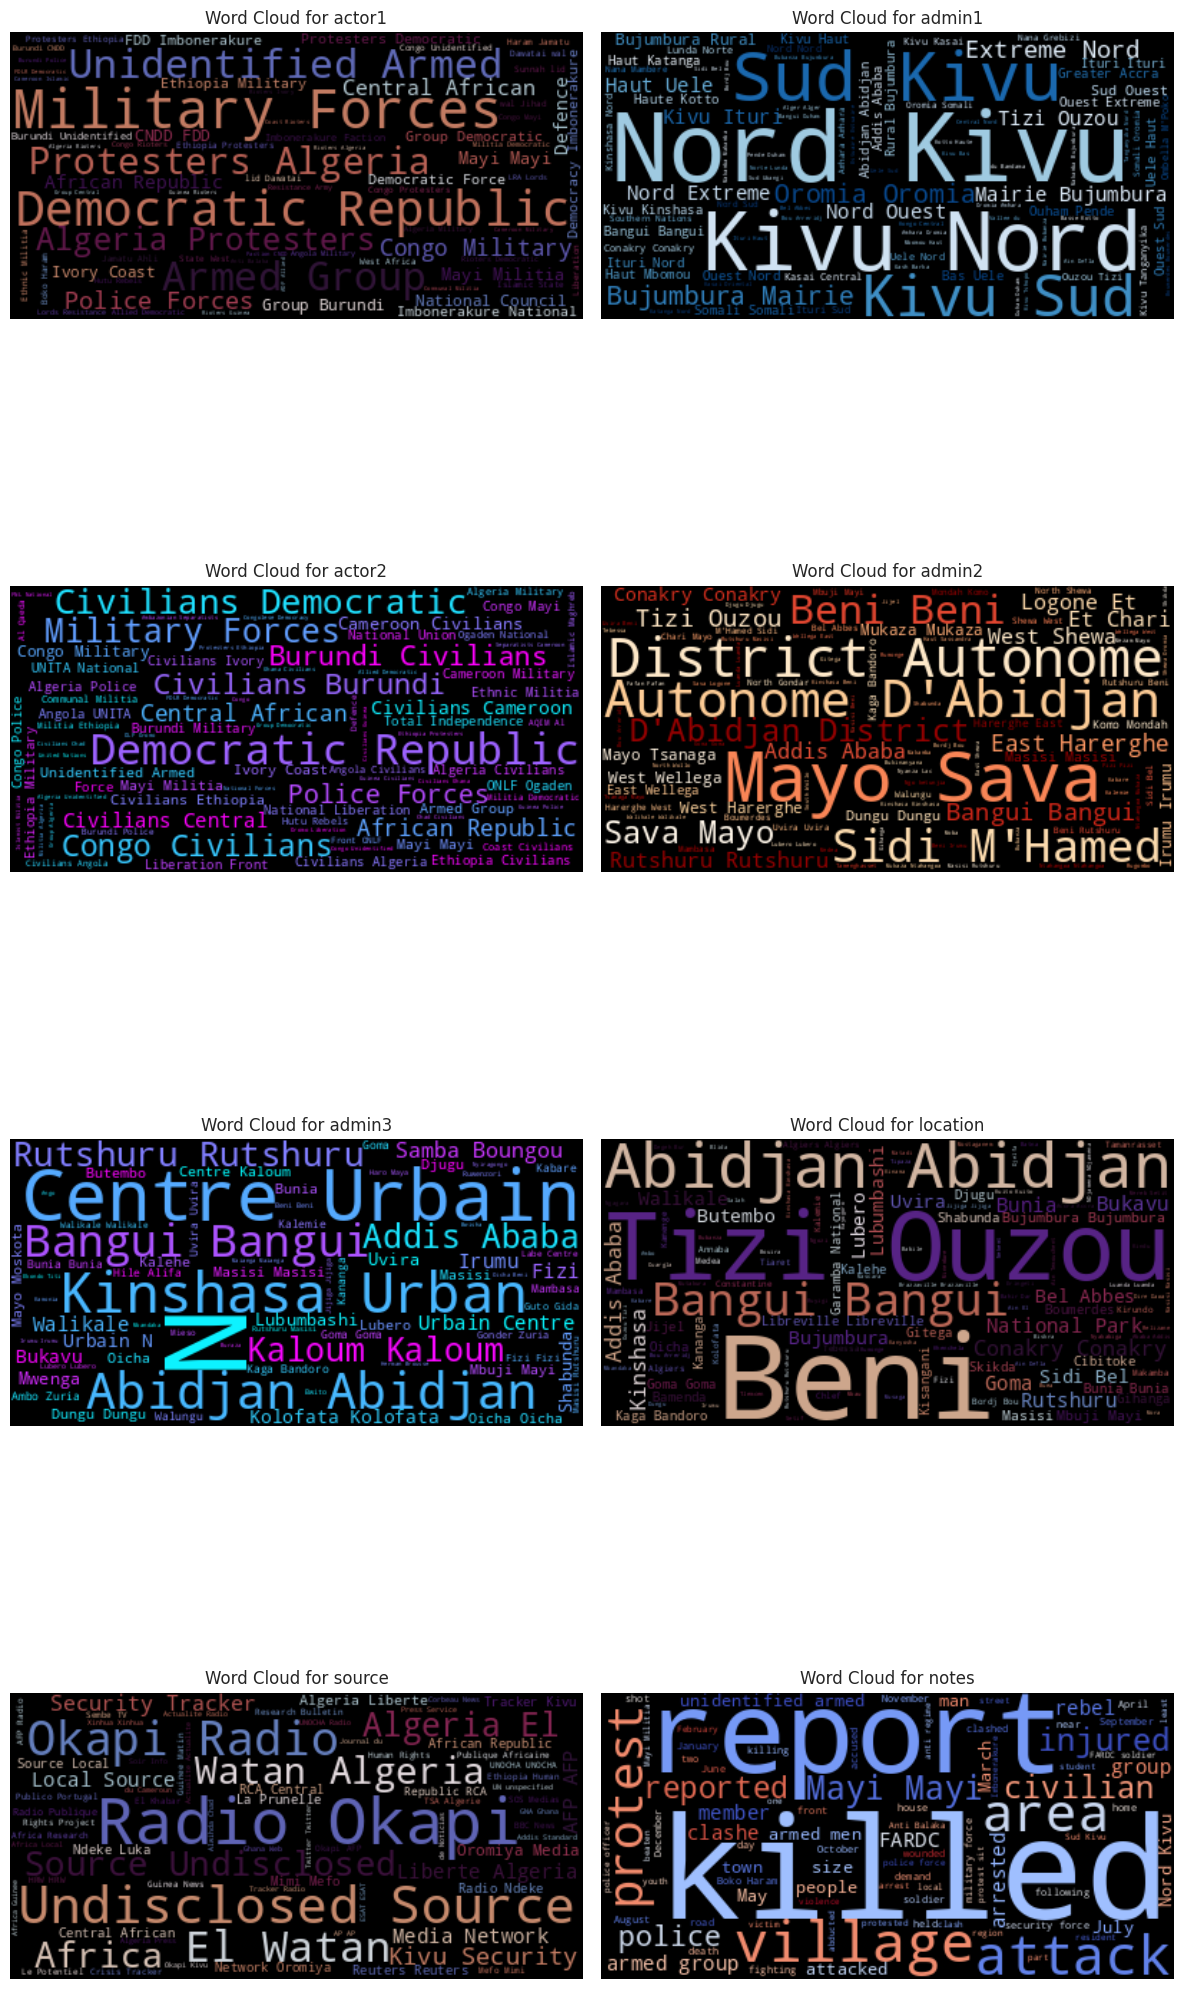

In [32]:
from wordcloud import WordCloud
import random
colors = ['OrRd', 'cividis', 'coolwarm', 'Blues', 'twilight', 'cool']

# Create a subplot grid based on the number of columns
num_columns = len(cat_col_high)
num_rows = (num_columns // 2) + (num_columns % 2)
fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 6))

# Iterate through the columns and create word clouds
for i, col in enumerate(data[cat_col_high]):
    # Combine text from the current column into a single text string
    text = ' '.join(data[col])

    # Create a word cloud from the combined text
    wordcloud = WordCloud(width=400, height=200, colormap=random.choice(colors)).generate(text)

    # Determine the subplot location
    rows = i // 2
    cols = i % 2

    # Create a plot for the word cloud
    ax = axes[rows, cols]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Word Cloud for {col}')

# Adjust layout and display the word clouds
plt.tight_layout()

In [33]:
# data.info()

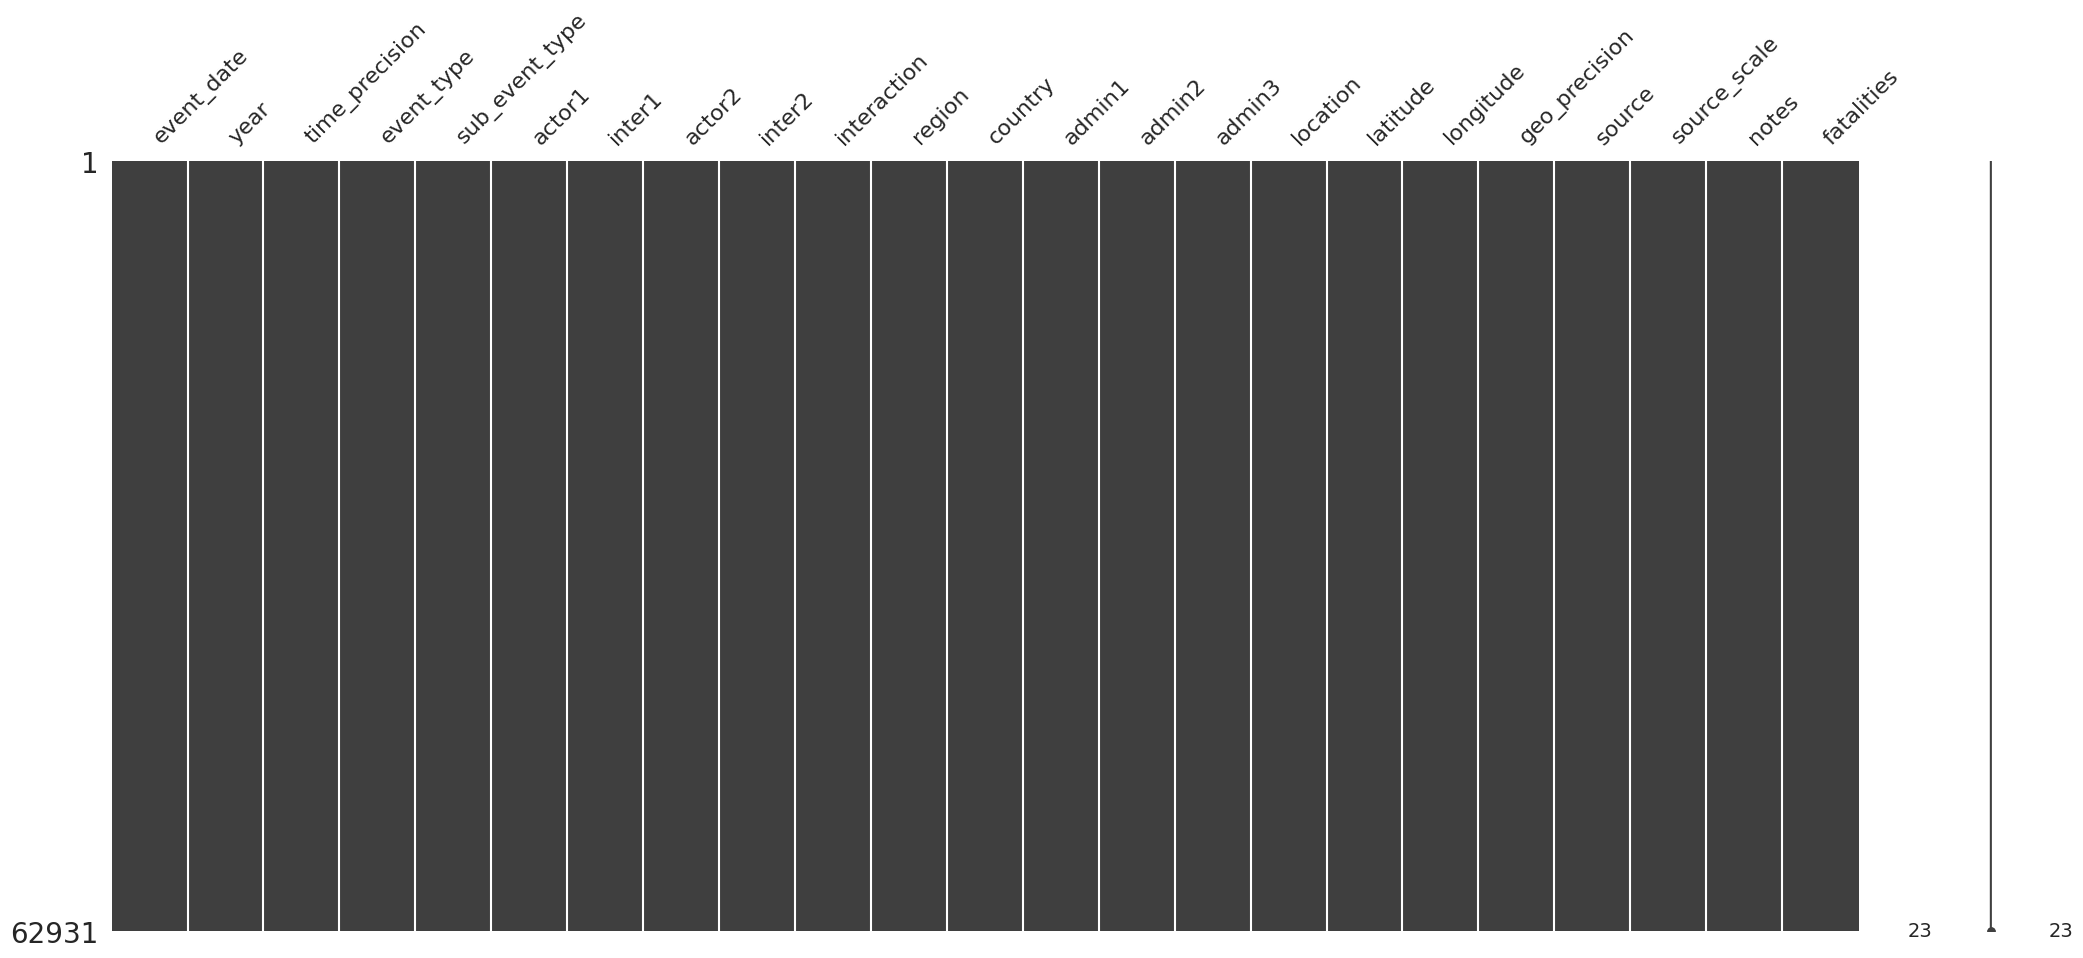

In [34]:
msno.matrix(data);

#### Numerical Variables

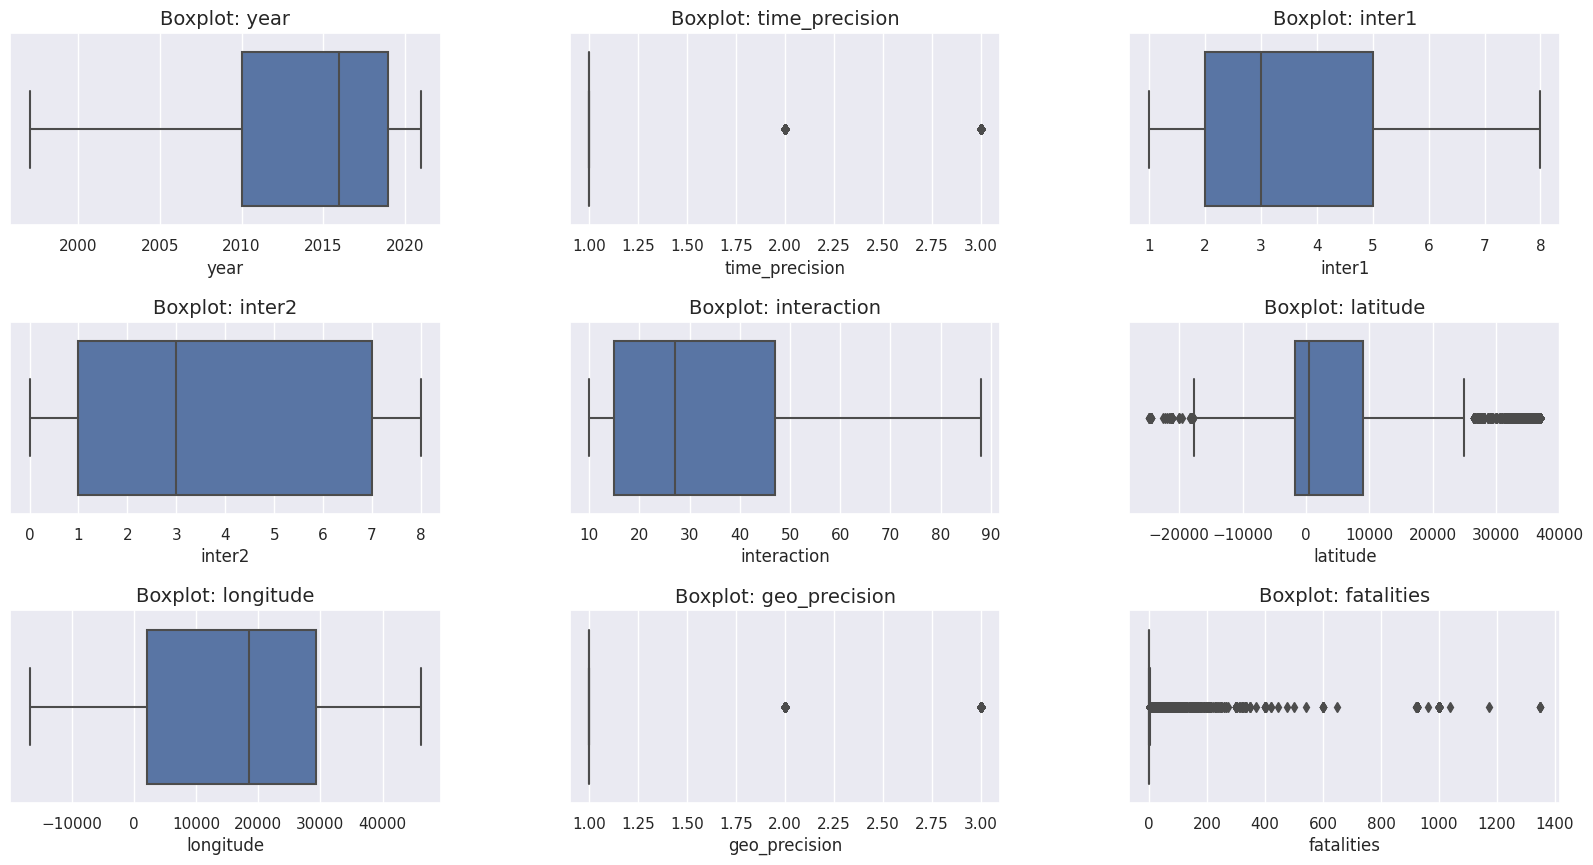

In [35]:
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(wspace=0.3, hspace=0.5)
for i, u in enumerate(num_col):
    ax = fig.add_subplot(3,3,i+1)
    sns.boxplot(x=u, data=data)
    ax.set_title('Boxplot: ' +u, fontsize=14)
plt.show()

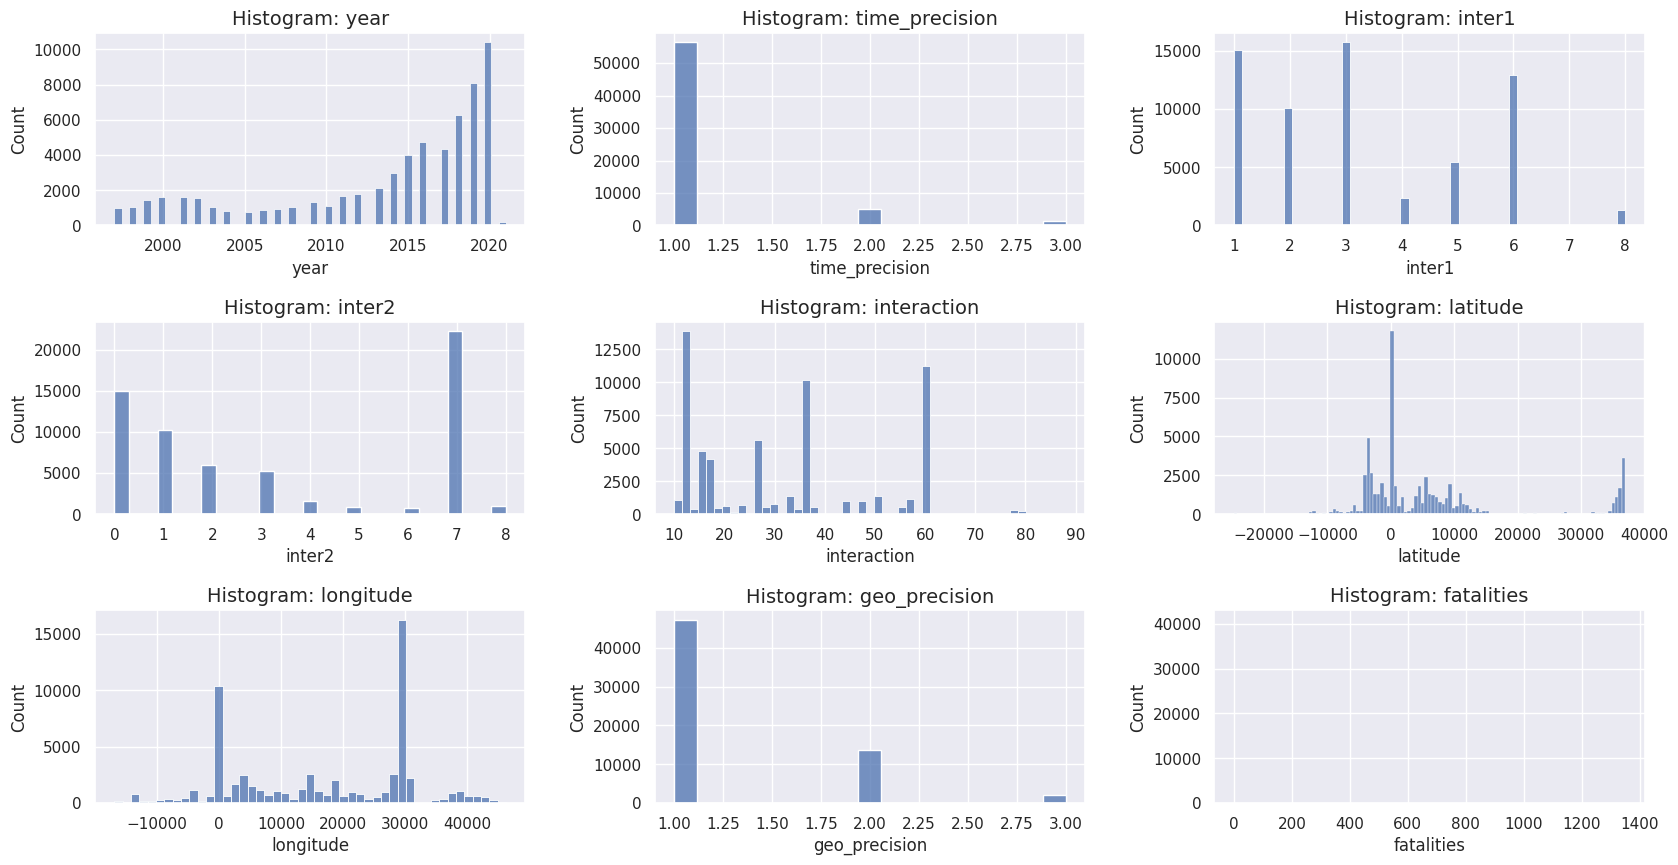

In [36]:
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(wspace=0.3, hspace=0.5)
for i, u in enumerate(num_col):
    ax = fig.add_subplot(3,3,i+1)
    sns.histplot(x=u, data=data)
    ax.set_title('Histogram: ' +u, fontsize=14)
plt.show()

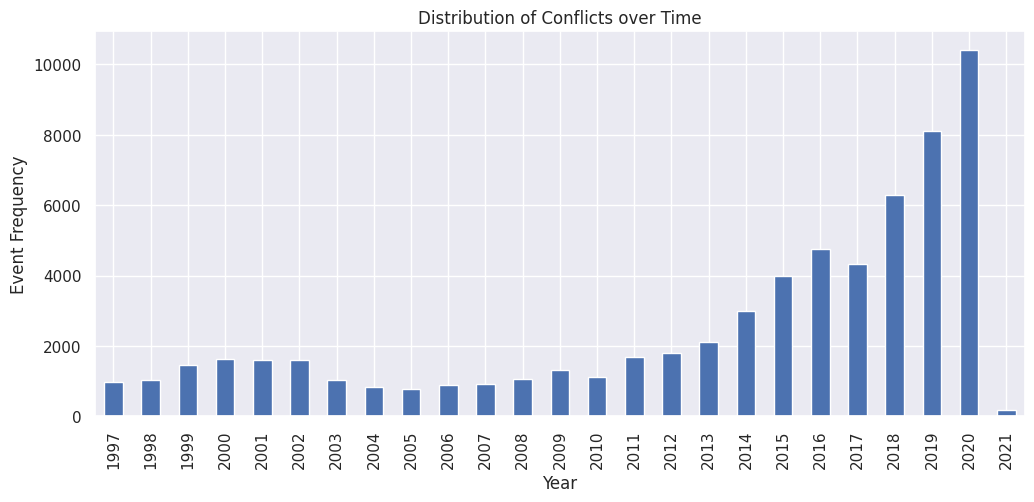

In [37]:
# frequency of events across year
events_by_year = data['year'].value_counts().sort_index()
events_by_year.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Event Frequency')
plt.title('Distribution of Conflicts over Time');

_We observed that in 2020, there were `10,413` reported events, making it the year with the highest conflict occurence. This suggests that 2020 was a year that experienced a significant number of incidents. While between 2016-2019 had a significant number of reported events. It can be said that these years signify periods of heightened conflict or incidents that received substantial attention and reporting._

### Bivariate Analysis

#### Countries and Years with Top Fatalities

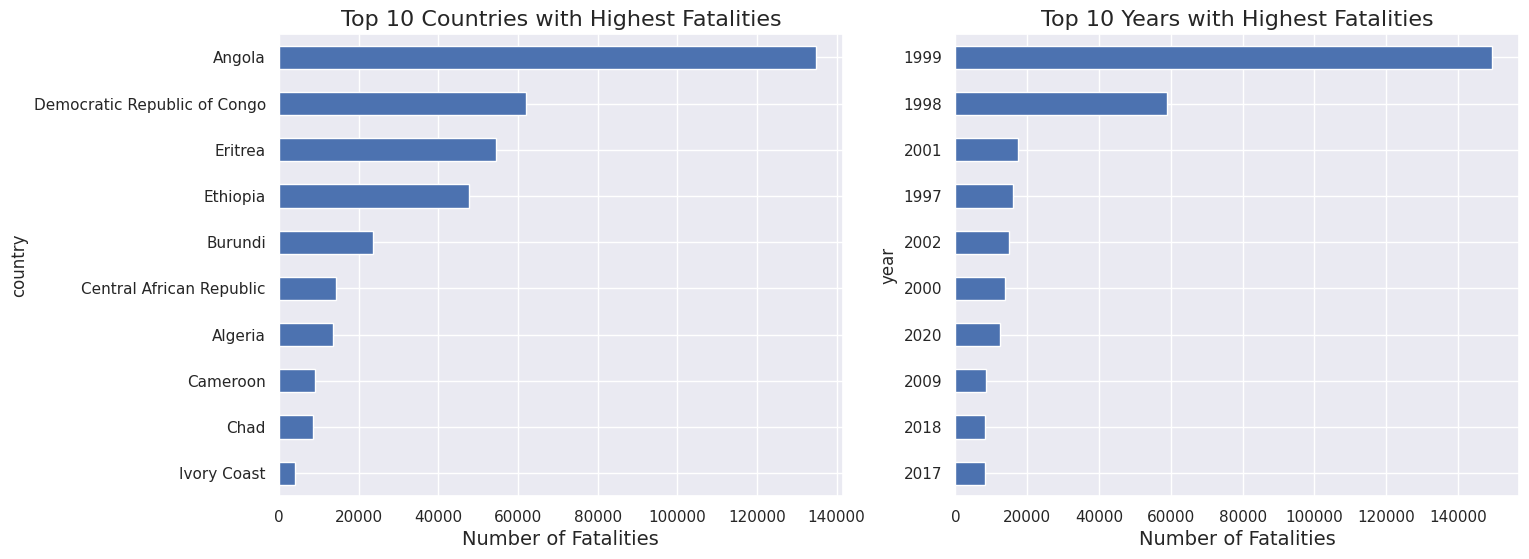

In [38]:
# Create a figure with a specific figure size
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Countries vs. Number of Fatalities
top_10_countries = data.groupby('country')['fatalities'].sum().sort_values(ascending=True).tail(10)
top_10_countries.plot.barh(ax=axes[0])
axes[0].set_title('Top 10 Countries with Highest Fatalities', fontsize=16)
axes[0].set_xlabel('Number of Fatalities', fontsize=14)

# Subplot 2: Years  vs. Number of Fatalities
top_10_years = data.groupby('year')['fatalities'].sum().sort_values(ascending=True).tail(10)
top_10_years.plot.barh(ax=axes[1])
axes[1].set_title('Top 10 Years with Highest Fatalities', fontsize=16)
axes[1].set_xlabel('Number of Fatalities', fontsize=14);

_For the analysis of fatalities, we discovered that the year 1999 had the highest number of reported deaths, accounting for approximately `39.5%` of the total fatalities._

_When examining the countries with the highest fatality rates, Angola emerged as the nation with the most reported deaths, accounting for approximately `35.6%` of the total fatalities._


#### Distribution of Events Across Regions

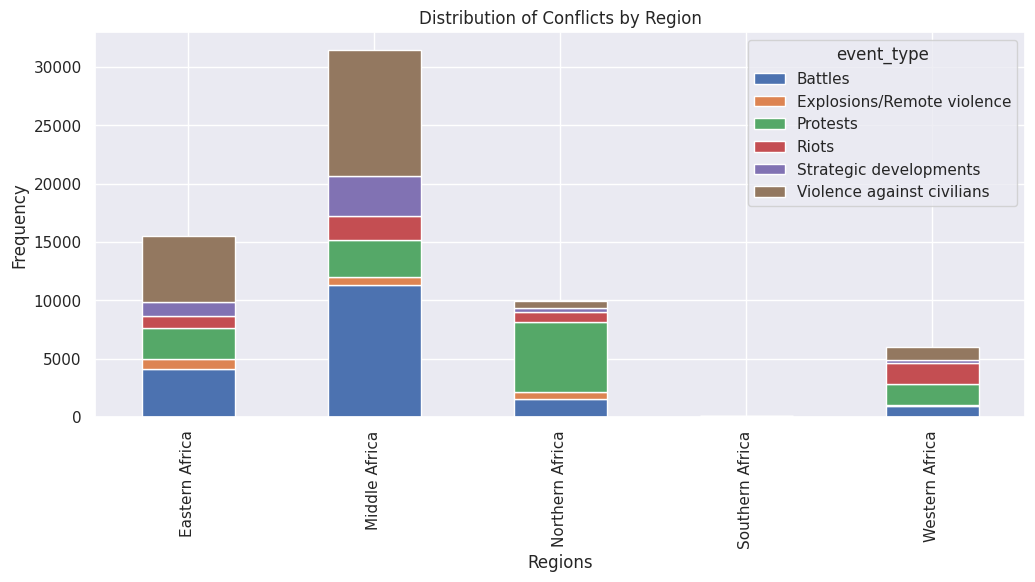

In [39]:
# Distribution of Events by Region
event_by_region = data.groupby(['region', 'event_type']).size().unstack(fill_value=0)

# Create the grouped bar chart
event_by_region.plot(kind='bar', stacked=True)

# Add labels and title to the plot
plt.xlabel('Regions')
plt.ylabel('Frequency')
plt.title('Distribution of Conflicts by Region')
plt.xticks(rotation=90);

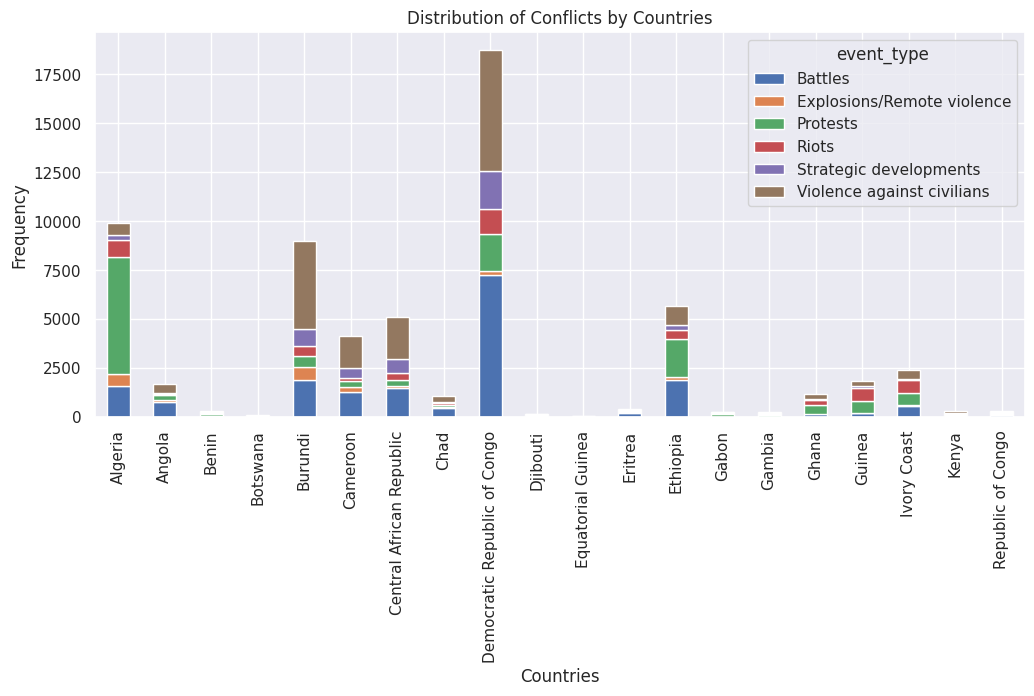

In [40]:
# Distribution of Events by Region
event_by_countries = data.groupby(['country', 'event_type']).size().unstack(fill_value=0)

# Create the grouped bar chart
event_by_countries.plot(kind='bar', stacked=True)

# Add labels and title to the plot
plt.xlabel('Countries')
plt.ylabel('Frequency')
plt.title('Distribution of Conflicts by Countries')
plt.xticks(rotation=90);

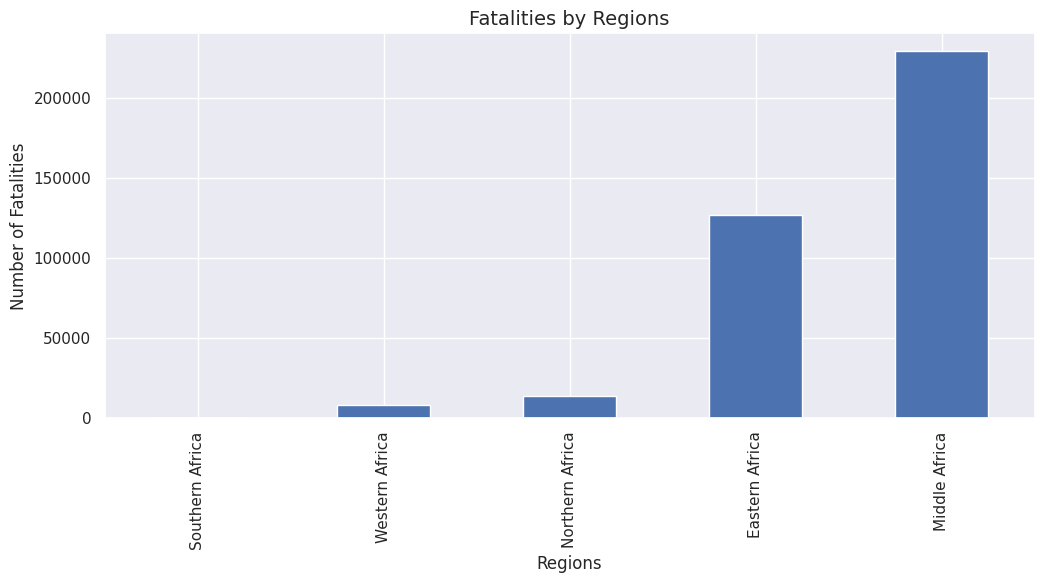

In [41]:
# Number of Fatalities by Region
fatalities_by_region = data.groupby(['region'])['fatalities'].sum().sort_values()
fatalities_by_region.plot.bar()
plt.title('Fatalities by Regions', fontsize=14)
plt.xlabel('Regions', fontsize=12)
plt.ylabel('Number of Fatalities', fontsize=12);

In [42]:
data.groupby(['region'])[['fatalities']].sum()

fatalities
region                     
Eastern Africa       126879
Middle Africa        229232
Northern Africa       13612
Southern Africa          10
Western Africa         8420

_We uncover the number of fatalities associated with each region. Shockingly, Eastern Africa and Middle Africa have witnessed the highest number of fatalities, with a staggering total of `126,879` and `229,232` respectively. These numbers serve as a stark reminder of the human cost of these conflicts._

_It is safe to say that Eastern and Middle Africa, known for their hostility, are less peaceful than the Southern region of Africa._

#### Top Event Actors

In [43]:
# Top event actors
top_actors = pd.concat([data['actor1'], data['actor2']]).value_counts().sort_values(ascending=True).tail(15)
top_actors

Military Forces of the Democratic Republic of Congo (2019-)                                     1554
Military Forces of Algeria (1999-)                                                              1752
CNDD-FDD-Imbonerakure: National Council for the Defence of Democracy (Imbonerakure Faction)     1866
Protesters (Democratic Republic of Congo)                                                       1908
Protesters (Ethiopia)                                                                           1920
Civilians (Cameroon)                                                                            2175
Unidentified Armed Group (Burundi)                                                              2334
Military Forces of Ethiopia (1995-2018)                                                         2438
Unidentified Armed Group (Democratic Republic of Congo)                                         2465
Civilians (Central African Republic)                                                       

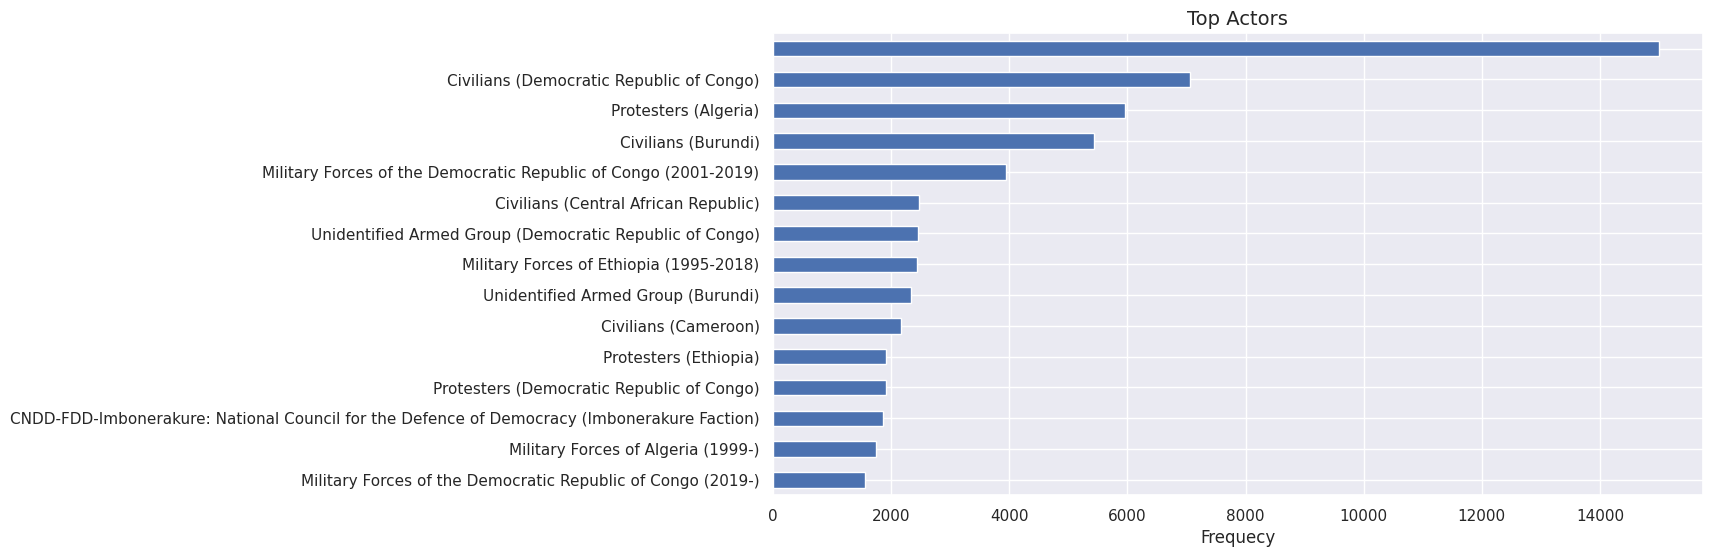

In [44]:
plt.figure(figsize=(12,6))
top_actors.plot(kind='barh')
plt.title('Top Actors', fontsize=14)
plt.xlabel('Frequecy', fontsize=12);

#### Source scale vs Fatalities

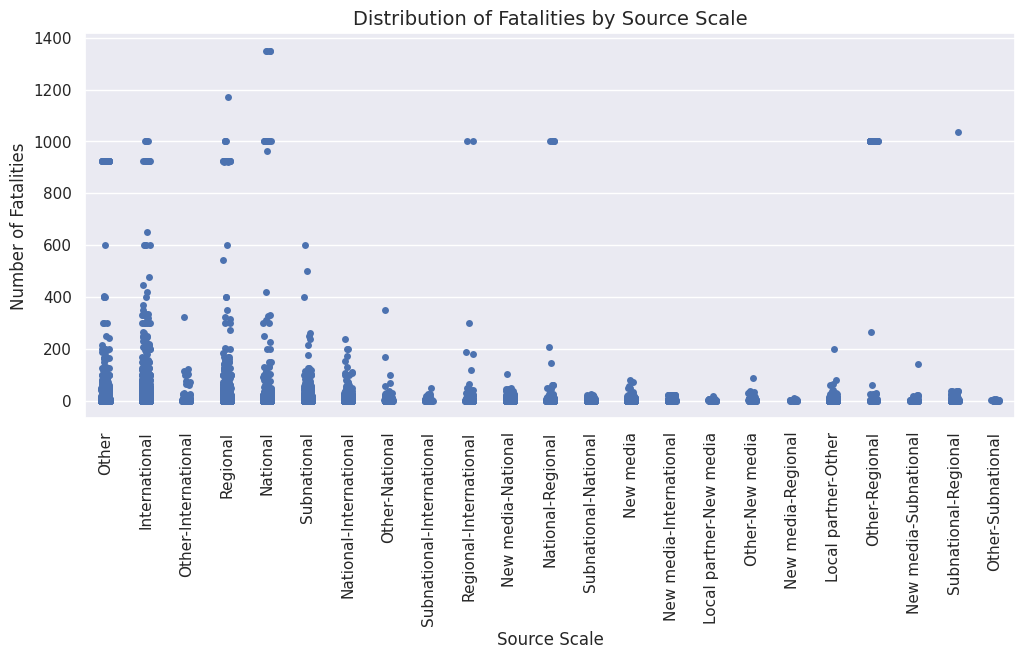

In [45]:
# Source scale vs Fatalities
sns.stripplot(x='source_scale', y='fatalities', data=data)
plt.xlabel('Source Scale', fontsize=12)
plt.ylabel('Number of Fatalities', fontsize=12)
plt.title('Distribution of Fatalities by Source Scale', fontsize=14)
plt.xticks(rotation=90);

### Multivariate Analysis

#### Relationship between event types, regions, and the number of fatalities

In [46]:
region_event = pd.pivot_table(data, values='fatalities', index='event_type', columns='region', aggfunc=np.sum, fill_value=0)
region_event

region                      Eastern Africa  Middle Africa  Northern Africa  \
event_type                                                                   
Battles                             101154         161979             5734   
Explosions/Remote violence            2024           9926             1594   
Protests                              1052            143                1   
Riots                                 1108           2414              200   
Strategic developments                   5             18                2   
Violence against civilians           21536          54752             6081   

region                      Southern Africa  Western Africa  
event_type                                                   
Battles                                   1            3044  
Explosions/Remote violence                0             201  
Protests                                  0             334  
Riots                                     4             616  
Strategic developments                    0               0  
Violence against civilians                5            4225

<Figure size 1600x600 with 0 Axes>

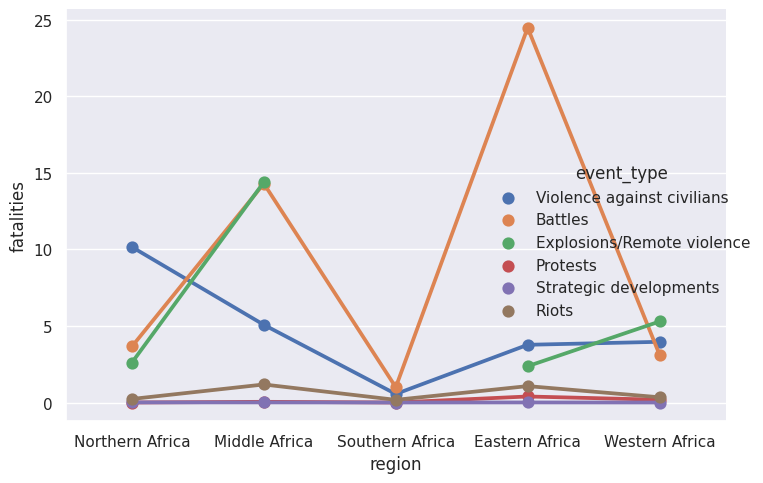

In [47]:
# Use catplot with kind='point' to create a point plot with a linear regression line
plt.figure(figsize=(16,6))
sns.catplot(x='region', y='fatalities', hue='event_type', kind='point', data=data, errorbar=None, legend=True)
plt.tight_layout()

#### Relationship between different actors and their interactions and the number of fatalities.

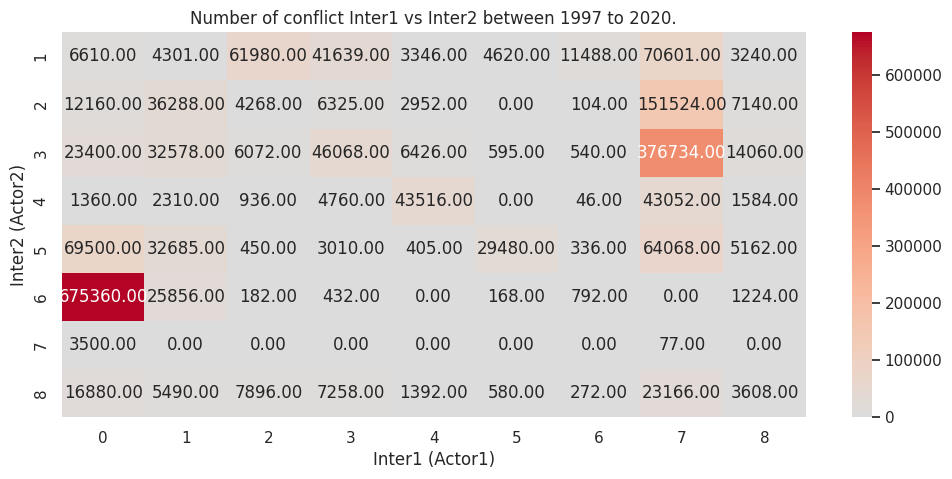

In [48]:
# Subset the number conflict caused by the by the interaction of the two actors
interaction = data.pivot_table(index='inter1', columns='inter2', values='interaction', aggfunc='sum', fill_value=0)

# Plot
plt.figure(figsize=(12, 5))
sns.heatmap(interaction, center=0, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Number of conflict Inter1 vs Inter2 between 1997 to 2020.')
plt.xlabel('Inter1 (Actor1)')
plt.ylabel('Inter2 (Actor2)');

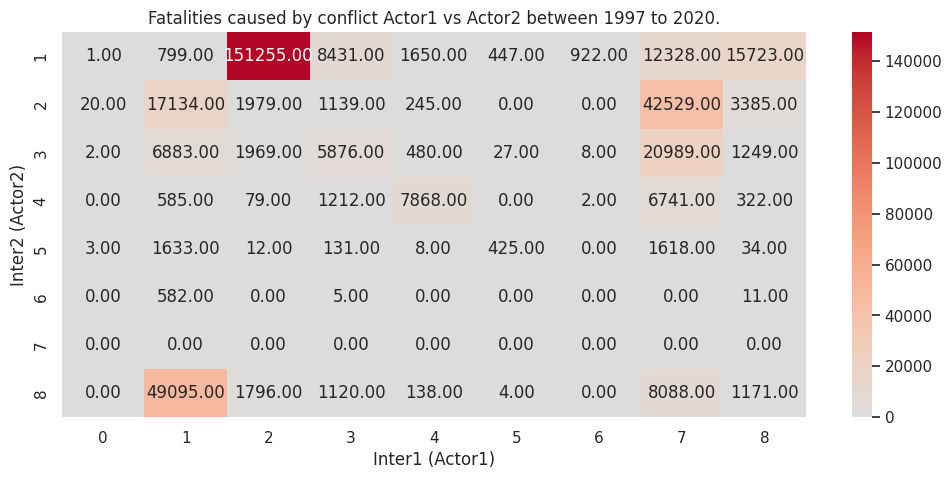

In [49]:
# Subset the number of fatalities caused by the by the interaction of the two actors
fatalities_interaction =  data.pivot_table(index='inter1', columns='inter2', values='fatalities', aggfunc='sum', fill_value=0)

# Plot
plt.figure(figsize=(12, 5))
sns.heatmap(fatalities_interaction, center=0, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Fatalities caused by conflict Actor1 vs Actor2 between 1997 to 2020.')
plt.xlabel('Inter1 (Actor1)')
plt.ylabel('Inter2 (Actor2)');

#### Total number of fatalities for each combination of event type and source scale.

In [50]:
# Group source scale into four categories (International, Regional, National, & Local)
data["source_scale_en"] = (
    np.where(data["source_scale"].str.contains("International", case=False), "International",
    np.where(data["source_scale"].str.contains("National", case=False, regex=True), "Regional",
    np.where(data["source_scale"].str.contains("Regional", case=False, regex=True), "National", "Local")))
)

In [51]:
print(data["source_scale_en"].value_counts())
print(data.shape)

Regional         27727
Local            14877
International    14045
National          6282
Name: source_scale_en, dtype: int64
(62931, 24)


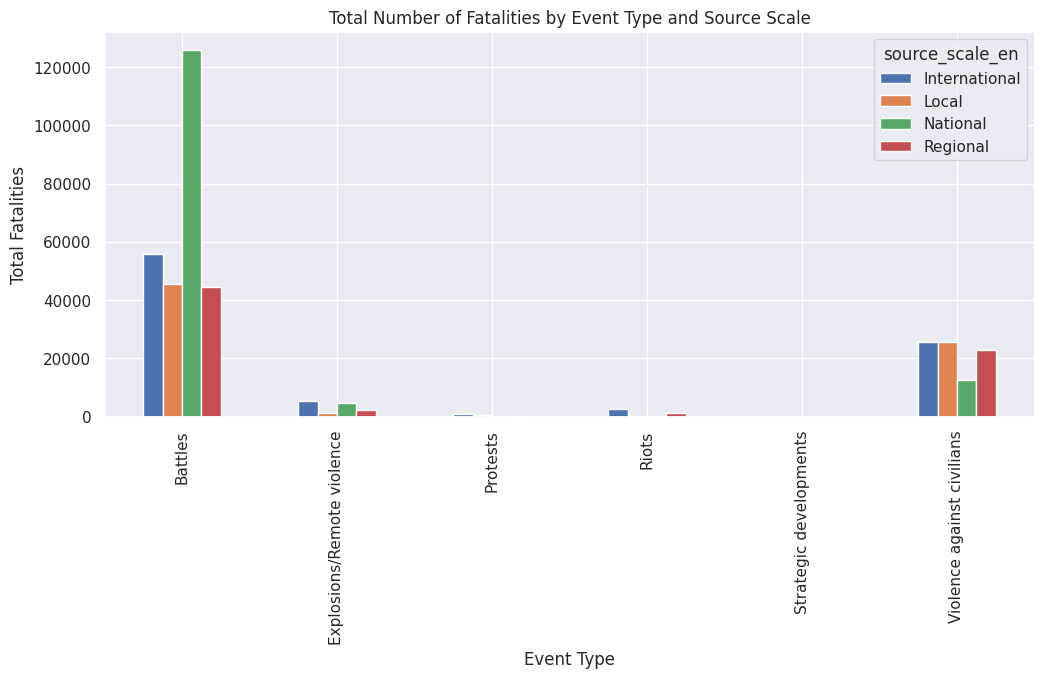

In [52]:
grouped_data = data.groupby(['event_type', 'source_scale_en'])['fatalities'].sum().unstack()

# Create the grouped bar chart
grouped_data.plot(kind='bar', stacked=False)

# Add labels and title to the plot
plt.xlabel('Event Type')
plt.ylabel('Total Fatalities')
plt.title('Total Number of Fatalities by Event Type and Source Scale');

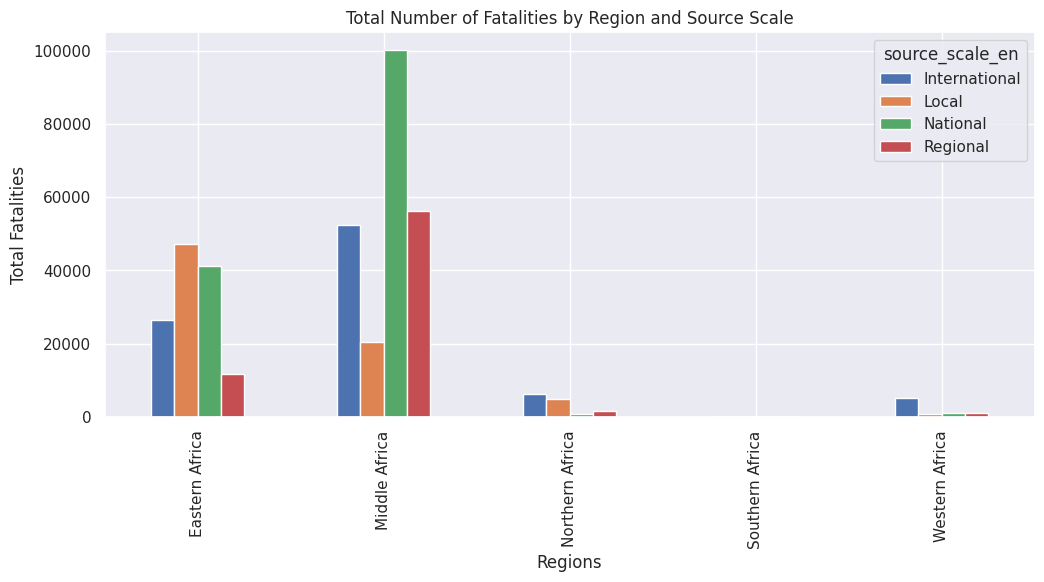

In [53]:
redion_scale = data.groupby(['region', 'source_scale_en'])['fatalities'].sum().unstack()

# Create the grouped bar chart
redion_scale.plot(kind='bar', stacked=False)

# Add labels and title to the plot
plt.xlabel('Regions')
plt.ylabel('Total Fatalities')
plt.title('Total Number of Fatalities by Region and Source Scale');

### Geospatial Analysis

#### Map plot of event_type, latitude and logitude

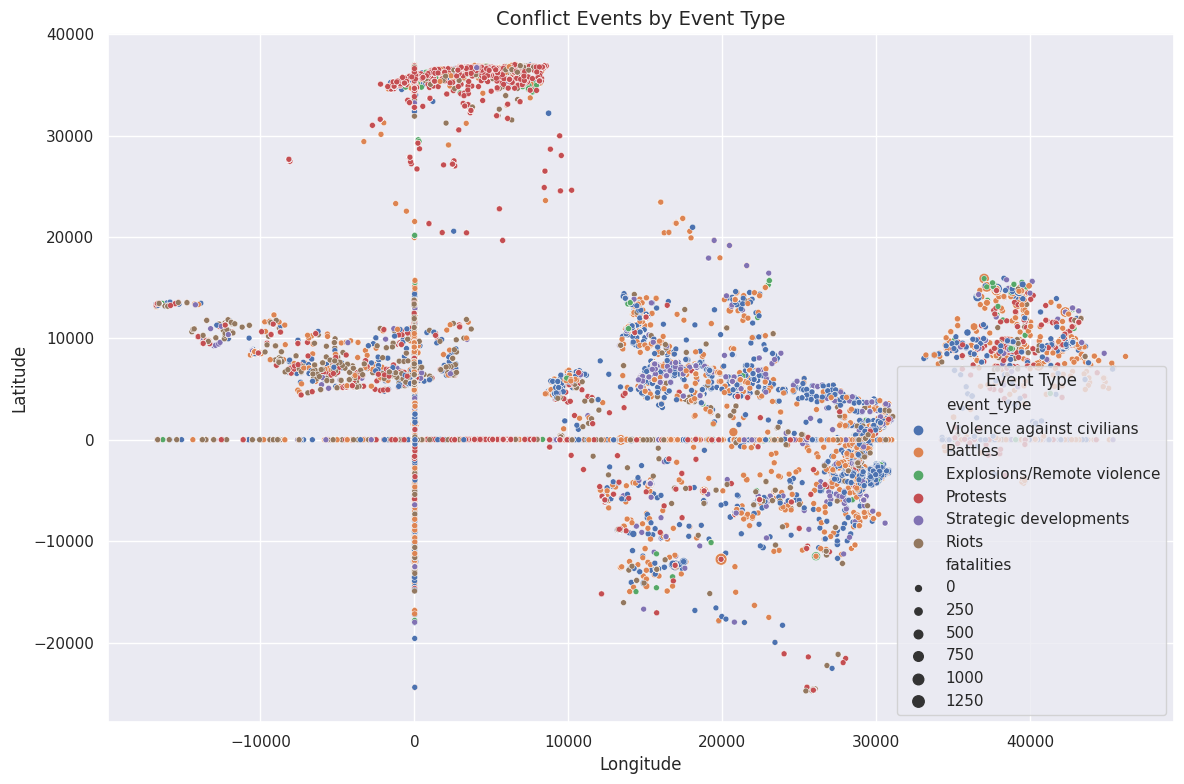

In [55]:
# event_type, latitude, and longitude (Map plot)
plt.figure(figsize=(12, 8))
sns.scatterplot(x='longitude', y='latitude', hue='event_type', size='fatalities', data=data)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('Conflict Events by Event Type', fontsize=14)
plt.legend(title='Event Type')
plt.tight_layout()

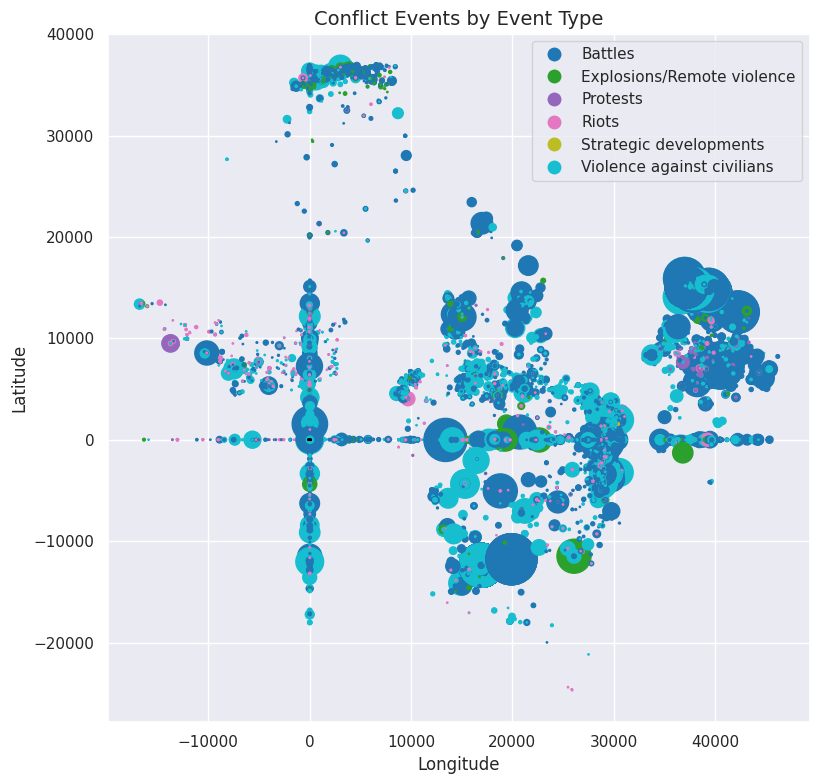

In [57]:
# Convert the dataframe to a geopandas dataframe
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))

# Create a map plot using the geopandas dataframe
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(12, 8))
world.boundary.plot(ax=ax, linewidth=0.5, color='black')
gdf.plot(ax=ax, markersize='fatalities', column='event_type', legend=True)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('Conflict Events by Event Type', fontsize=14)
plt.tight_layout()

### Time Series

In [58]:
cal_fatalities = data.groupby('event_date')['fatalities'].agg('sum')

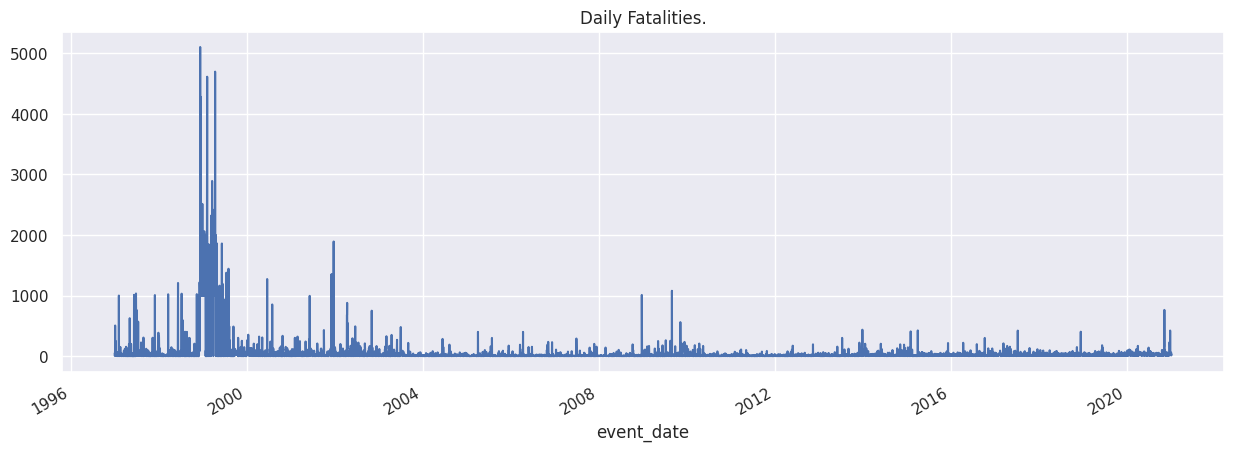

In [59]:
fig, ax = plt.subplots(figsize=(15,5))
cal_fatalities.plot(ax=ax)
ax.set_title('Daily Fatalities.');

In [60]:
# Perform time series decomposition to identify patterns or trends
ts = data['year'].value_counts().sort_index()
period = 12 # Specify the period length
data['event_date'] = pd.to_datetime(data['event_date'])
data.set_index('event_date', inplace=True)

# Perform time series decomposition
decomposition = seasonal_decompose(ts, model='additive', period=period)

# Access the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

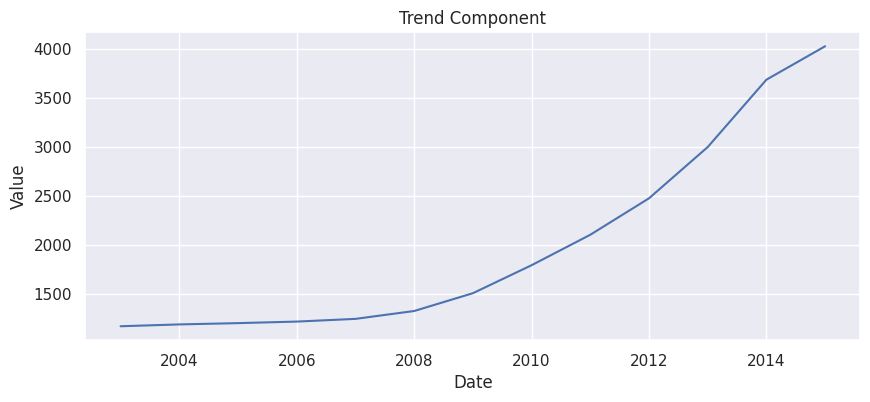

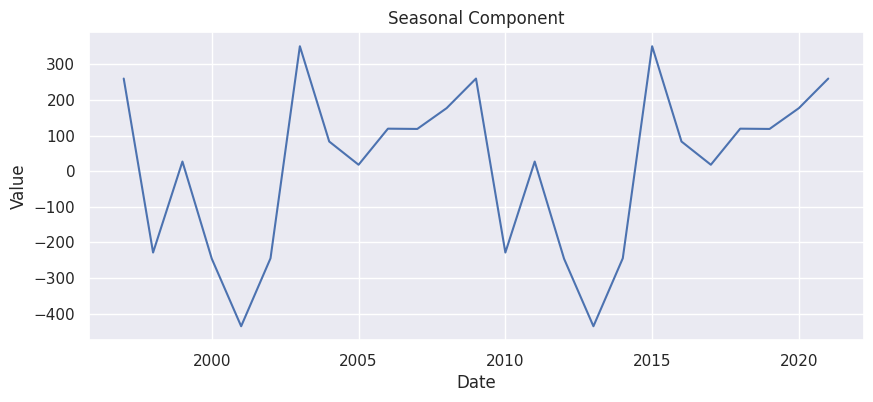

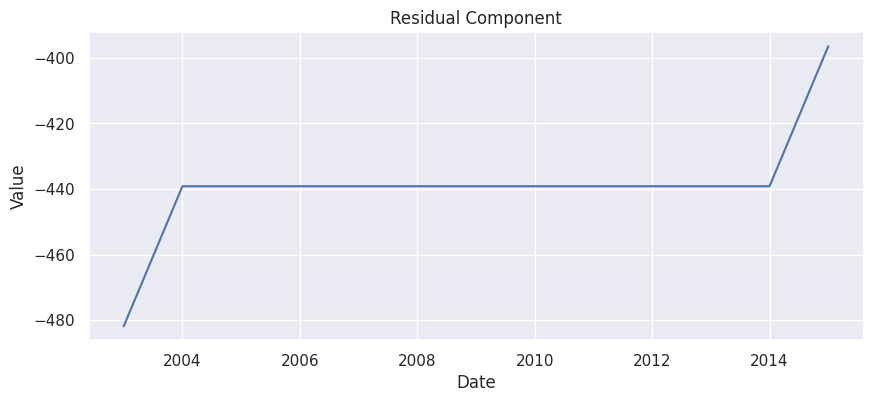

In [62]:
# Plot the trend component
plt.figure(figsize=(10, 4))
plt.plot(trend)
plt.title('Trend Component')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Plot the seasonal component
plt.figure(figsize=(10, 4))
plt.plot(seasonal)
plt.title('Seasonal Component')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Plot the residual component
plt.figure(figsize=(10, 4))
plt.plot(residual)
plt.title('Residual Component')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

### Contributors:
- Oluwafemi Abiona
- Eke Mong Eke
- Linda Owolabi